In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shelve
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
def get_swc_df(swc_path):

    with open(swc_path, "rb") as f: #rb = read only, binary
        data = f.read().decode("utf-8")  #utf is a unicode standard

    data = data.replace('\r\n', '\n').split('\n')
    data_list = [line.split(" ") for line in data if not line.strip().startswith('#')]

    df = pd.DataFrame(data_list) 
    df = df.replace('', np.nan)
    df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')  # drop blank rows and cols
    df.columns = ["sample", "structure", "x", "y", "z", "diameter", "parent"]
    # add assert to check that vals are within normal ranges
    df = df.set_index("sample") #index up until the last
    df = df.astype({"structure":int, "x":float, "y":float, "z":float, "diameter":float, "parent":int})
    df.index = df.index.astype(int) #1, 2, 3 not "1" etc

    return df

In [31]:
swc_path_toy = './data/toy_data/3_populations/neurons/1.swc'
df_toy = get_swc_df(swc_path_toy)

swc_path_urban = './data/urban_data/neurons/soma_centered/interneuron_granule_adult-bornCell-3-4.swc'
df_urban = get_swc_df(swc_path_urban)

In [4]:
def draw_neuron(swc_df, a='x', b='y', marker_color='green', ax=None):
    if ax is None:  
        plt.figure(figsize=(8, 8))
        ax=plt.gca()
    
    x = []; y = []
    for sample in swc_df.index:
        parent = swc_df.loc[sample, 'parent']
        if sample>1 and parent == (sample-1): # If this is contiguous with the previous sample
            x.append(swc_df.loc[sample, a]) # Just append to the list of points to draw
            y.append(swc_df.loc[sample, b]) # Ditto
        else: # If it is not contiguous (i.e. new branch)
            ax.plot(x, y, 'o-', markersize=0.5, color=marker_color) # Draw the x,y so far accumulated
            x = [swc_df.loc[sample, a]] # And start a new list of x's for this new branch
            y = [swc_df.loc[sample, b]] # Ditto for y

In [5]:
def apply_scale(df):  #, x, y, z):
    # scale the x, y, z values so they range [0,1]
    df['x_abs'] = df['x'].abs()
    df['y_abs'] = df['y'].abs()
    df['z_abs'] = df['z'].abs()
    
    scaler = MinMaxScaler()
    df['x_scaled'] = scaler.fit_transform(np.array(df['x_abs']).reshape(-1, 1))
    df['y_scaled'] = scaler.fit_transform(np.array(df['y_abs']).reshape(-1, 1))
    df['z_scaled'] = scaler.fit_transform(np.array(df['z_abs']).reshape(-1, 1))
    # assert that final result has mean abs value of 1 in each dim column

    return df 

In [32]:
df_toy_scaled = apply_scale(df_toy)
df_urban_scaled = apply_scale(df_urban)


In [33]:
df_toy_scaled

,structure,x,y,z,diameter,parent,x_abs,y_abs,z_abs,x_scaled,y_scaled,z_scaled
sample,,,,,,,,,,,,
0,3,0.00,0.00,0.00,1.0,-1,0.00,0.00,0.00,0.000000,0.000000,0.000000
1,3,0.35,0.64,-0.56,1.0,0,0.35,0.64,0.56,0.050725,0.083225,0.086420
2,3,0.71,1.28,-1.42,1.0,1,0.71,1.28,1.42,0.102899,0.166450,0.219136
3,3,0.74,0.90,-1.80,1.0,1,0.74,0.90,1.80,0.107246,0.117035,0.277778
4,3,1.10,1.51,-1.84,1.0,2,1.10,1.51,1.84,0.159420,0.196359,0.283951
...,...,...,...,...,...,...,...,...,...,...,...,...
195,3,-3.18,1.54,-0.11,1.0,163,3.18,1.54,0.11,0.460870,0.200260,0.016975
196,3,-3.25,1.52,-3.53,1.0,164,3.25,1.52,3.53,0.471014,0.197659,0.544753
197,3,-3.10,0.76,1.65,1.0,165,3.10,0.76,1.65,0.449275,0.098830,0.254630


In [24]:
df_urban_scaled

,structure,x,y,z,diameter,parent,x_abs,y_abs,z_abs,x_scaled,y_scaled,z_scaled
sample,,,,,,,,,,,,
1,1,0.00,0.00,0.00,2.05597,-1,0.00,0.00,0.00,0.000000,0.000000,0.000000
2,1,2.05,0.16,0.00,2.05597,1,2.05,0.16,0.00,0.043067,0.000716,0.000000
3,1,-2.04,-0.15,0.00,2.05597,1,2.04,0.15,0.00,0.042857,0.000671,0.000000
4,3,-1.37,8.11,0.79,0.98000,1,1.37,8.11,0.79,0.028782,0.036290,0.032958
5,3,-2.12,10.35,0.79,0.54500,4,2.12,10.35,0.79,0.044538,0.046313,0.032958
...,...,...,...,...,...,...,...,...,...,...,...,...
363,4,6.82,-5.82,0.00,0.38000,362,6.82,5.82,0.00,0.143277,0.026043,0.000000
364,4,7.74,-6.29,0.00,0.38000,363,7.74,6.29,0.00,0.162605,0.028146,0.000000
365,4,8.33,-7.11,0.00,0.38000,364,8.33,7.11,0.00,0.175000,0.031815,0.000000


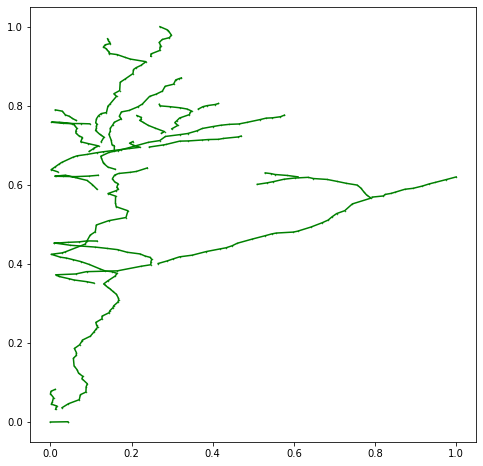

In [29]:
draw_neuron(df_urban_scaled, a = 'x_scaled', b= 'y_scaled')

In [3]:

db = shelve.open('scalings.db')


scaled_neurons = {}
for neuron_name in my_neurons:
    swc = get_swc_df(neuron_path)
    x, y, z = determine_scale(swc, neuron_path)
    swc_scaled = apply_scale(swc, x, y, z)
    scaled_neurons[neuron_name] = swc_scaled

#db['fake_neuron'] = {'x': 3, 'y': 4.2, 'z': 2.1}
#db.close()

SyntaxError: invalid syntax (2488164440.py, line 5)

Text(0.5, 0, 'distance (um)')

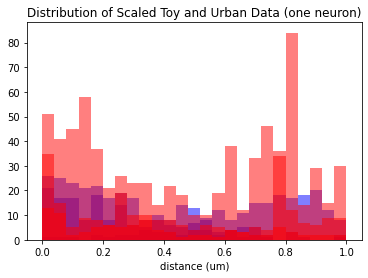

In [57]:
plt.hist(df_toy['x_scaled'], bins=25, alpha=0.5, color = 'blue');
plt.hist(df_toy['y_scaled'], bins=25, alpha=0.5, color = 'blue');
plt.hist(df_toy['z_scaled'], bins=25, alpha=0.5, color = 'blue');

plt.hist(df_urban['x_scaled'], bins=25, alpha=0.5, color = 'red');
plt.hist(df_urban['y_scaled'], bins=25, alpha=0.5, color = 'red');
plt.hist(df_urban['z_scaled'], bins=25, alpha=0.5, color = 'red');

plt.title('Distribution of Scaled Toy and Urban Data (one neuron)')
plt.xlabel('distance (um)')


In [ ]:
# misc 
line = '5 7 9 # this is the soma  '
line.strip().startswith('#')